## imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.structured import *

import time
from gplearn.genetic import SymbolicTransformer
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import gc
from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

#will ignore all warning from sklearn, seaborn etc..

In [4]:
PATH = os.getcwd();
PATH

'D:\\Github\\fastai\\courses\\ml1'

In [32]:
df_raw  = pd.read_csv(f'{PATH}\\AV_Stud\\train_HK6lq50_encoded_v3_250518.csv', low_memory= False)
df_test = pd.read_csv(f'{PATH}\\AV_Stud\\test_2nAIblo_encoded_v3_250518.csv',  low_memory=False)

## init fe

In [5]:
df_raw.head(2)

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,trainee_id,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,Matriculation,3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School Diploma,4,26.0,2,N,3.0,1


In [6]:
#dropping id columns
df_raw.drop(['id','trainee_id'], inplace = True, axis =1)
df_test.drop(['id', 'trainee_id'], inplace = True, axis =1);

target = df_raw.is_pass;
df_raw.drop('is_pass', axis =1, inplace= True)

df_raw['age'].fillna(value = 45., inplace=True)
df_raw['trainee_engagement_rating'].fillna(value = 1., inplace=True)

In [34]:
df_raw.head(3)

,program_id,program_type,program_duration,test_id,test_type,difficulty_level,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,trainee_engagement_rating
0,Y_1,Y,136,150,offline,intermediate,M,Matriculation,3,24.0,5,N,1
1,T_1,T,131,44,offline,easy,F,High School Diploma,4,26.0,2,N,3
2,Z_2,Z,120,178,online,easy,M,Matriculation,1,40.0,1,N,2


In [38]:
#############################################################################################################
##########################################TRAIN SET FE'S######################################################
#############################################################################################################

df_raw['program_type__program_duration'] = df_raw.program_type.str.cat(df_raw.program_duration.astype(str),sep='_')
df_raw['program_type__city_tier'] = df_raw.program_type.str.cat(df_raw.city_tier.astype(str),sep='_')
df_raw['program_type__test_type'] = df_raw.program_type.str.cat(df_raw.test_type.astype(str),sep='_')
df_raw['program_type__difficulty_level'] = df_raw.program_type.str.cat(df_raw.difficulty_level.astype(str),sep='_')

df_raw['test_id__program_duration'] = df_raw.test_id.astype(str).str.cat(df_raw.program_duration.astype(str),sep='_')
df_raw['test_id__test_type'] = df_raw.test_id.astype(str).str.cat(df_raw.test_type.astype(str),sep='_')
df_raw['test_id_test_type__difficulty_level'] = df_raw.test_id__test_type.str.cat(df_raw.difficulty_level.astype(str),sep='_')
df_raw['test_type__difficulty_level'] = df_raw.test_type.str.cat(df_raw.difficulty_level.astype(str),sep='_')

df_raw['education__gender'] = df_raw.education.str.cat(df_raw.gender.astype(str),sep='_')
df_raw['education__total_programs_enrolled'] = df_raw.education.str.cat(df_raw.total_programs_enrolled.astype(str),sep='_')
df_raw['gender__city_tier'] = df_raw.gender.str.cat(df_raw.city_tier.astype(str),sep='_')
df_raw['gender__is_handicapped'] = df_raw.gender.str.cat(df_raw.is_handicapped.astype(str),sep='_')
df_raw['education__city_tier'] = df_raw.education.str.cat(df_raw.city_tier.astype(str),sep='_')

df_raw['program_duration_months'] = df_raw['program_duration'] / (7.)
df_raw['program_duration_years'] = df_raw['program_duration'] / (365.)
df_raw['program_duration_avg'] = df_raw['program_duration']/df_raw['total_programs_enrolled']

df_raw['is_age_39'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age<=39.').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_age_39_45'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=39. & age<=45.').index
df_raw.iloc[my_query, -1] = 1

df_raw['is_age_45'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('age>=45.').index
df_raw.iloc[my_query, -1] = 1

###################young age (13–30), middle age (31–50) and senior age (51–70)########################

df_raw['age_group'] = np.zeros(df_raw.shape[0])

my_query = df_raw.query('age>=13. & age<=30.').index
df_raw.iloc[my_query, -1] = 'young'

my_query = df_raw.query('age>=31. & age<=50.').index
df_raw.iloc[my_query, -1] = 'middle_aged'

my_query = df_raw.query('age>=51. & age<=70.').index
df_raw.iloc[my_query, -1] = 'senior_aged'

df_raw['program_level'] = df_raw['program_id'].str.split(pat='_', expand=True).get(1).astype(object)

#df_raw['is_pass'] = target
#df_raw.drop('is_pass', axis = 1, inplace = True);

#############################################################################################################
##########################################TEST SET FE'S######################################################
#############################################################################################################

df_test['program_type__program_duration'] = df_test.program_type.str.cat(df_test.program_duration.astype(str),sep='_')
df_test['program_type__city_tier'] = df_test.program_type.str.cat(df_test.city_tier.astype(str),sep='_')
df_test['program_type__test_type'] = df_test.program_type.str.cat(df_test.test_type.astype(str),sep='_')
df_test['program_type__difficulty_level'] = df_test.program_type.str.cat(df_test.difficulty_level.astype(str),sep='_')

df_test['test_id__program_duration'] = df_test.test_id.astype(str).str.cat(df_test.program_duration.astype(str),sep='_')
df_test['test_id__test_type'] = df_test.test_id.astype(str).str.cat(df_test.test_type.astype(str),sep='_')
df_test['test_id_test_type__difficulty_level'] = df_test.test_id__test_type.str.cat(df_test.difficulty_level.astype(str),sep='_')
df_test['test_type__difficulty_level'] = df_test.test_type.str.cat(df_test.difficulty_level.astype(str),sep='_')

df_test['education__gender'] = df_test.education.str.cat(df_test.gender.astype(str),sep='_')
df_test['education__total_programs_enrolled'] = df_test.education.str.cat(df_test.total_programs_enrolled.astype(str),sep='_')
df_test['gender__city_tier'] = df_test.gender.str.cat(df_test.city_tier.astype(str),sep='_')
df_test['gender__is_handicapped'] = df_test.gender.str.cat(df_test.is_handicapped.astype(str),sep='_')
df_test['education__city_tier'] = df_test.education.str.cat(df_test.city_tier.astype(str),sep='_')

df_test['program_duration_months'] = df_test['program_duration'] / (7.)
df_test['program_duration_years'] = df_test['program_duration'] / (365.)
df_test['program_duration_avg'] = df_test['program_duration']/df_test['total_programs_enrolled']

df_test['is_age_39'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age<=39.').index
df_test.iloc[my_query, -1] = 1

df_test['is_age_39_45'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=39. & age<=45.').index
df_test.iloc[my_query, -1] = 1

df_test['is_age_45'] = np.zeros(df_test.shape[0])
my_query = df_test.query('age>=45.').index
df_test.iloc[my_query, -1] = 1

###################young age (13–30), middle age (31–50) and senior age (51–70)########################

df_test['age_group'] = np.zeros(df_test.shape[0])

my_query = df_test.query('age>=13. & age<=30.').index
df_test.iloc[my_query, -1] = 'young'

my_query = df_test.query('age>=31. & age<=50.').index
df_test.iloc[my_query, -1] = 'middle_aged'

my_query = df_test.query('age>=51. & age<=70.').index
df_test.iloc[my_query, -1] = 'senior_aged'

df_test['program_level'] = df_test['program_id'].str.split(pat='_', expand=True).get(1).astype(object)

########################################### Dropping few cols ##############################################3
df_raw.drop('program_id', inplace=True, axis =1)
df_test.drop('program_id', inplace=True, axis =1)

In [83]:
##################### sanity check  should be empty #####################
set(df_raw.columns) - set(df_test.columns)

set()

In [84]:
# This way we have randomness and are able to reproduce the behaviour within this cell.
np.random.seed(13)
from sklearn.model_selection import KFold

def impact_coding(data, feature, target='y'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 10
    n_inner_folds = 7
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [85]:
features = df_raw.columns
numeric_features = []
categorical_features = []

for dtype, feature in zip(df_raw.dtypes, df_raw.columns):
    if dtype == object:
        categorical_features.append(feature)
    else:
        numeric_features.append(feature)
categorical_features

['program_type',
 'test_type',
 'difficulty_level',
 'gender',
 'education',
 'is_handicapped',
 'trainee_engagement_rating',
 'program_type__program_duration',
 'program_type__city_tier',
 'program_type__test_type',
 'program_type__difficulty_level',
 'test_id__program_duration',
 'test_id__test_type',
 'test_id_test_type__difficulty_level',
 'test_type__difficulty_level',
 'education__gender',
 'education__total_programs_enrolled',
 'gender__city_tier',
 'gender__is_handicapped',
 'education__city_tier',
 'age_group',
 'program_level']

In [86]:
%%time
# Apply the encoding to training and test data, and preserve the mapping
df_raw['is_pass'] = target
impact_coding_map = {}
for f in categorical_features:
    print("Impact coding for {}".format(f))
    df_raw["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(df_raw, f,'is_pass')
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    df_test["impact_encoded_{}".format(f)] = df_test.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)
df_raw.drop('is_pass', inplace=True, axis=1)

Impact coding for program_type
Impact coding for test_type
Impact coding for difficulty_level
Impact coding for gender
Impact coding for education
Impact coding for is_handicapped
Impact coding for trainee_engagement_rating
Impact coding for program_type__program_duration
Impact coding for program_type__city_tier
Impact coding for program_type__test_type
Impact coding for program_type__difficulty_level
Impact coding for test_id__program_duration
Impact coding for test_id__test_type
Impact coding for test_id_test_type__difficulty_level
Impact coding for test_type__difficulty_level
Impact coding for education__gender
Impact coding for education__total_programs_enrolled
Impact coding for gender__city_tier
Impact coding for gender__is_handicapped
Impact coding for education__city_tier
Impact coding for age_group
Impact coding for program_level
Wall time: 54min 3s


In [89]:
df_raw['is_pass'] = target

In [90]:
df_raw.to_csv(f'{PATH}\\AV_Stud\\train_HK6lq50_encoded_v3_250518.csv',index=False)
df_test.to_csv(f'{PATH}\\AV_Stud\\test_2nAIblo_encoded_v3_250518.csv',index=False)

## modelling part

In [92]:
categorical_features_indices = np.where(df_raw.dtypes == 'object')[0];
df_raw.drop('is_pass',axis=1,inplace=True);
categorical_features_indices

array([ 0,  3,  4,  5,  6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 31, 32], dtype=int64)

In [94]:
X_train, X_validation, y_train, y_validation = train_test_split(df_raw, target, train_size=0.8, random_state=1234, shuffle=True)

model=CatBoostClassifier(iterations=1000, depth=12, learning_rate=0.01, loss_function='Logloss',use_best_model=True,\
                class_weights = [0.3045921227117995, 0.6954078772882005 ])

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation));

0:	learn: 0.6867808	test: 0.6867312	best: 0.6867312 (0)	total: 1.87s	remaining: 31m 7s
1:	learn: 0.6807377	test: 0.6808033	best: 0.6808033 (1)	total: 2.11s	remaining: 17m 32s
2:	learn: 0.6746046	test: 0.6746514	best: 0.6746514 (2)	total: 2.85s	remaining: 15m 45s
3:	learn: 0.6688808	test: 0.6689656	best: 0.6689656 (3)	total: 3.01s	remaining: 12m 30s
4:	learn: 0.6638230	test: 0.6639022	best: 0.6639022 (4)	total: 3.13s	remaining: 10m 22s
5:	learn: 0.6579859	test: 0.6579568	best: 0.6579568 (5)	total: 3.62s	remaining: 10m
6:	learn: 0.6523715	test: 0.6523962	best: 0.6523962 (6)	total: 4.06s	remaining: 9m 36s
7:	learn: 0.6467625	test: 0.6468480	best: 0.6468480 (7)	total: 4.73s	remaining: 9m 46s
8:	learn: 0.6413260	test: 0.6414122	best: 0.6414122 (8)	total: 5.24s	remaining: 9m 37s
9:	learn: 0.6365543	test: 0.6366293	best: 0.6366293 (9)	total: 5.4s	remaining: 8m 54s
10:	learn: 0.6317368	test: 0.6318091	best: 0.6318091 (10)	total: 5.64s	remaining: 8m 27s
11:	learn: 0.6271710	test: 0.6272396	best

92:	learn: 0.4579479	test: 0.4571913	best: 0.4571913 (92)	total: 1m 10s	remaining: 11m 26s
93:	learn: 0.4572930	test: 0.4565368	best: 0.4565368 (93)	total: 1m 10s	remaining: 11m 23s
94:	learn: 0.4566578	test: 0.4559054	best: 0.4559054 (94)	total: 1m 11s	remaining: 11m 16s
95:	learn: 0.4560140	test: 0.4552682	best: 0.4552682 (95)	total: 1m 11s	remaining: 11m 11s
96:	learn: 0.4554011	test: 0.4546595	best: 0.4546595 (96)	total: 1m 11s	remaining: 11m 4s
97:	learn: 0.4547904	test: 0.4540550	best: 0.4540550 (97)	total: 1m 11s	remaining: 10m 59s
98:	learn: 0.4542052	test: 0.4534753	best: 0.4534753 (98)	total: 1m 11s	remaining: 10m 53s
99:	learn: 0.4536269	test: 0.4529036	best: 0.4529036 (99)	total: 1m 11s	remaining: 10m 47s
100:	learn: 0.4530708	test: 0.4523511	best: 0.4523511 (100)	total: 1m 12s	remaining: 10m 41s
101:	learn: 0.4525133	test: 0.4517994	best: 0.4517994 (101)	total: 1m 12s	remaining: 10m 36s
102:	learn: 0.4519800	test: 0.4512694	best: 0.4512694 (102)	total: 1m 12s	remaining: 10

182:	learn: 0.4313868	test: 0.4308210	best: 0.4308210 (182)	total: 1m 31s	remaining: 6m 49s
183:	learn: 0.4312910	test: 0.4307265	best: 0.4307265 (183)	total: 1m 31s	remaining: 6m 46s
184:	learn: 0.4311989	test: 0.4306364	best: 0.4306364 (184)	total: 1m 31s	remaining: 6m 44s
185:	learn: 0.4311084	test: 0.4305479	best: 0.4305479 (185)	total: 1m 32s	remaining: 6m 42s
186:	learn: 0.4310182	test: 0.4304588	best: 0.4304588 (186)	total: 1m 32s	remaining: 6m 40s
187:	learn: 0.4309306	test: 0.4303733	best: 0.4303733 (187)	total: 1m 32s	remaining: 6m 39s
188:	learn: 0.4308455	test: 0.4302903	best: 0.4302903 (188)	total: 1m 32s	remaining: 6m 36s
189:	learn: 0.4307593	test: 0.4302082	best: 0.4302082 (189)	total: 1m 32s	remaining: 6m 36s
190:	learn: 0.4306771	test: 0.4301294	best: 0.4301294 (190)	total: 1m 33s	remaining: 6m 34s
191:	learn: 0.4305951	test: 0.4300498	best: 0.4300498 (191)	total: 1m 33s	remaining: 6m 33s
192:	learn: 0.4305164	test: 0.4299737	best: 0.4299737 (192)	total: 1m 33s	remain

272:	learn: 0.4274579	test: 0.4270283	best: 0.4270283 (272)	total: 1m 43s	remaining: 4m 35s
273:	learn: 0.4273999	test: 0.4269743	best: 0.4269743 (273)	total: 1m 43s	remaining: 4m 34s
274:	learn: 0.4273853	test: 0.4269607	best: 0.4269607 (274)	total: 1m 44s	remaining: 4m 34s
275:	learn: 0.4273711	test: 0.4269473	best: 0.4269473 (275)	total: 1m 44s	remaining: 4m 33s
276:	learn: 0.4273574	test: 0.4269343	best: 0.4269343 (276)	total: 1m 44s	remaining: 4m 32s
277:	learn: 0.4273439	test: 0.4269215	best: 0.4269215 (277)	total: 1m 44s	remaining: 4m 31s
278:	learn: 0.4273306	test: 0.4269090	best: 0.4269090 (278)	total: 1m 44s	remaining: 4m 30s
279:	learn: 0.4273176	test: 0.4268967	best: 0.4268967 (279)	total: 1m 44s	remaining: 4m 29s
280:	learn: 0.4273050	test: 0.4268848	best: 0.4268848 (280)	total: 1m 44s	remaining: 4m 27s
281:	learn: 0.4272925	test: 0.4268730	best: 0.4268730 (281)	total: 1m 44s	remaining: 4m 26s
282:	learn: 0.4272804	test: 0.4268615	best: 0.4268615 (282)	total: 1m 44s	remain

362:	learn: 0.4267890	test: 0.4264172	best: 0.4264172 (362)	total: 1m 53s	remaining: 3m 18s
363:	learn: 0.4267867	test: 0.4264152	best: 0.4264152 (363)	total: 1m 53s	remaining: 3m 17s
364:	learn: 0.4267844	test: 0.4264131	best: 0.4264131 (364)	total: 1m 53s	remaining: 3m 17s
365:	learn: 0.4267821	test: 0.4264112	best: 0.4264112 (365)	total: 1m 53s	remaining: 3m 16s
366:	learn: 0.4267799	test: 0.4264092	best: 0.4264092 (366)	total: 1m 53s	remaining: 3m 15s
367:	learn: 0.4267777	test: 0.4264073	best: 0.4264073 (367)	total: 1m 53s	remaining: 3m 14s
368:	learn: 0.4267756	test: 0.4264055	best: 0.4264055 (368)	total: 1m 53s	remaining: 3m 14s
369:	learn: 0.4267735	test: 0.4264037	best: 0.4264037 (369)	total: 1m 53s	remaining: 3m 13s
370:	learn: 0.4267715	test: 0.4264019	best: 0.4264019 (370)	total: 1m 53s	remaining: 3m 12s
371:	learn: 0.4267687	test: 0.4264001	best: 0.4264001 (371)	total: 1m 53s	remaining: 3m 12s
372:	learn: 0.4267667	test: 0.4263984	best: 0.4263984 (372)	total: 1m 53s	remain

452:	learn: 0.4266850	test: 0.4263352	best: 0.4263352 (452)	total: 2m	remaining: 2m 25s
453:	learn: 0.4266846	test: 0.4263349	best: 0.4263349 (453)	total: 2m	remaining: 2m 24s
454:	learn: 0.4266843	test: 0.4263347	best: 0.4263347 (454)	total: 2m	remaining: 2m 24s
455:	learn: 0.4266839	test: 0.4263344	best: 0.4263344 (455)	total: 2m	remaining: 2m 23s
456:	learn: 0.4266835	test: 0.4263342	best: 0.4263342 (456)	total: 2m	remaining: 2m 23s
457:	learn: 0.4266832	test: 0.4263339	best: 0.4263339 (457)	total: 2m	remaining: 2m 22s
458:	learn: 0.4266829	test: 0.4263337	best: 0.4263337 (458)	total: 2m	remaining: 2m 22s
459:	learn: 0.4266825	test: 0.4263334	best: 0.4263334 (459)	total: 2m	remaining: 2m 21s
460:	learn: 0.4266822	test: 0.4263332	best: 0.4263332 (460)	total: 2m 1s	remaining: 2m 21s
461:	learn: 0.4266819	test: 0.4263330	best: 0.4263330 (461)	total: 2m 1s	remaining: 2m 21s
462:	learn: 0.4266815	test: 0.4263328	best: 0.4263328 (462)	total: 2m 1s	remaining: 2m 20s
463:	learn: 0.4266812	t

543:	learn: 0.4266681	test: 0.4263258	best: 0.4263258 (543)	total: 2m 7s	remaining: 1m 46s
544:	learn: 0.4266680	test: 0.4263258	best: 0.4263258 (544)	total: 2m 7s	remaining: 1m 46s
545:	learn: 0.4266680	test: 0.4263258	best: 0.4263258 (545)	total: 2m 7s	remaining: 1m 45s
546:	learn: 0.4266679	test: 0.4263258	best: 0.4263258 (546)	total: 2m 7s	remaining: 1m 45s
547:	learn: 0.4266679	test: 0.4263258	best: 0.4263258 (547)	total: 2m 7s	remaining: 1m 45s
548:	learn: 0.4266678	test: 0.4263257	best: 0.4263257 (548)	total: 2m 7s	remaining: 1m 44s
549:	learn: 0.4266677	test: 0.4263257	best: 0.4263257 (549)	total: 2m 7s	remaining: 1m 44s
550:	learn: 0.4266677	test: 0.4263257	best: 0.4263257 (550)	total: 2m 7s	remaining: 1m 44s
551:	learn: 0.4266676	test: 0.4263257	best: 0.4263257 (551)	total: 2m 7s	remaining: 1m 43s
552:	learn: 0.4266676	test: 0.4263257	best: 0.4263257 (552)	total: 2m 7s	remaining: 1m 43s
553:	learn: 0.4266675	test: 0.4263257	best: 0.4263257 (553)	total: 2m 7s	remaining: 1m 42s

633:	learn: 0.4266655	test: 0.4263259	best: 0.4263256 (575)	total: 2m 12s	remaining: 1m 16s
634:	learn: 0.4266655	test: 0.4263259	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 16s
635:	learn: 0.4266655	test: 0.4263259	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 16s
636:	learn: 0.4266655	test: 0.4263259	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 15s
637:	learn: 0.4266654	test: 0.4263259	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 15s
638:	learn: 0.4266654	test: 0.4263259	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 15s
639:	learn: 0.4266654	test: 0.4263259	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 15s
640:	learn: 0.4266654	test: 0.4263260	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 14s
641:	learn: 0.4266654	test: 0.4263260	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 14s
642:	learn: 0.4266654	test: 0.4263260	best: 0.4263256 (575)	total: 2m 13s	remaining: 1m 14s
643:	learn: 0.4266654	test: 0.4263260	best: 0.4263256 (575)	total: 2m 13s	remain

724:	learn: 0.4266651	test: 0.4263265	best: 0.4263256 (575)	total: 2m 18s	remaining: 52.6s
725:	learn: 0.4266651	test: 0.4263266	best: 0.4263256 (575)	total: 2m 18s	remaining: 52.3s
726:	learn: 0.4266651	test: 0.4263266	best: 0.4263256 (575)	total: 2m 18s	remaining: 52.1s
727:	learn: 0.4266651	test: 0.4263266	best: 0.4263256 (575)	total: 2m 18s	remaining: 51.9s
728:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 18s	remaining: 51.6s
729:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 18s	remaining: 51.4s
730:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 18s	remaining: 51.1s
731:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 19s	remaining: 50.9s
732:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 19s	remaining: 50.7s
733:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 19s	remaining: 50.4s
734:	learn: 0.4266650	test: 0.4263266	best: 0.4263256 (575)	total: 2m 19s	remaining: 50.2s

815:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 32.5s
816:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 32.3s
817:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 32.1s
818:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 31.9s
819:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 31.7s
820:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 31.5s
821:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 31.3s
822:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 31.1s
823:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 30.9s
824:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 30.7s
825:	learn: 0.4266650	test: 0.4263269	best: 0.4263256 (575)	total: 2m 24s	remaining: 30.5s

906:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 29s	remaining: 15.4s
907:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 29s	remaining: 15.2s
908:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 29s	remaining: 15s
909:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 29s	remaining: 14.8s
910:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 14.7s
911:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 14.5s
912:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 14.3s
913:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 14.1s
914:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 14s
915:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 13.8s
916:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 30s	remaining: 13.6s
917

997:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 35s	remaining: 311ms
998:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 35s	remaining: 156ms
999:	learn: 0.4266650	test: 0.4263271	best: 0.4263256 (575)	total: 2m 35s	remaining: 0us

bestTest = 0.4263255838
bestIteration = 575

Shrink model to first 576 iterations.


In [106]:
prediction_proba = model.predict_proba(df_test)

In [22]:
gc.collect()

4388

In [7]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\AV_Stud\\sample_submission_vaSxamm.csv')
    submit = sample.copy()
    submit['is_pass'] = probs
    return submit

In [74]:
#submit = make_submission(prediction_proba[:,1]);
#submit = make_submission(preds_xgb)
submit = make_submission(new_preds)

In [75]:
submit.head(2)

,id,is_pass
0,1626_45,0.491504
1,11020_130,0.830501


In [76]:
submit.to_csv(f'{PATH}\\AV_Stud\\nn2.csv', index=False)

## xgb

In [33]:
target = df_raw['is_pass'];
df_raw.drop(['is_pass'], axis =1, inplace =True)

'''df_raw.drop(['is_pass','program_id', 'program_type', 'test_type', 'difficulty_level', 'gender',
       'education', 'is_handicapped'], inplace =True, axis =1)

df_test.drop(['program_id', 'program_type', 'test_type', 'difficulty_level', 'gender',
       'education', 'is_handicapped'], inplace =True, axis =1)
'''

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=1337)
folds = list(cv.split(df_raw, target))
x_trn, x_val, y_trn, y_val = train_test_split(df_raw, target, test_size=0.2, random_state=42, shuffle= True)
#sanity check
set(df_raw.columns) - set(df_test.columns)

set()

In [7]:
def cross_val_xgb(params, X, y, folds):
    n = 1
    num_rounds = 3000
    
    list_rounds = []
    list_scores = []
    
    for train_idx, valid_idx in folds:
        print('#################################')
        print('#########  Validating for fold:', n)

        xgtrain = xgb.DMatrix(X[train_idx], label=y[train_idx])
        xgtest = xgb.DMatrix(X[valid_idx], label=y[valid_idx])

        watchlist = [ (xgtest, 'test') ]
        model = xgb.train(params, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=True)
        
        rounds = model.best_ntree_limit
        score = model.best_score
        
        print('\nFold', n,'- best round:', rounds)
        print('Fold', n,'- best score:', score)
        
        list_rounds.append(rounds)
        list_scores.append(score)
        n +=1
    
    mean_score = np.mean(list_scores)
    std_score = np.std(list_scores)
    mean_round = np.mean(list_rounds)
    std_round = np.std(list_rounds)
    
    print('End cross validating',n-1,'folds') #otherwise it displays 6 folds
    print("Cross Validation Scores are: ", np.round(list_scores,3))
    print("Mean CrossVal score is: ", round(mean_score,3))
    print("Std Dev CrossVal score is: ", round(std_score,3))
    print("Cross Validation early stopping rounds are: ", np.round(list_rounds,3))
    print("Mean early stopping round is: ", round(mean_round,3))
    print("Std Dev early stopping round is: ", round(std_round,3))
    
    return mean_round, model_cv

In [8]:
def runXGB(train_X, train_y, test_X, test_y=None, seed_val=1, depth = 10):
    
        params = {}
        params['booster'] = 'gbtree'
        #params['updater'] = 'coord_descent'
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'auc'
        params["eta"] = 0.05 #0.00334
        params["subsample"] = .9
        params["silent"] = 0
        params['verbose'] = 2
        params["max_depth"] = depth
        params["seed"] = seed_val
        params["max_delta_step"] = 4
        params['scale_pos_weight'] =  0.4380049934141978
        #params['alpha'] = 0.05
        params["gamma"] = 0.3
        params['colsample_bytree'] = 0.9
        num_rounds = 2000 #3600

        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)
        
        if test_y is not None:
                print('1st block\n')
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds= 50,verbose_eval=True)
        else:
                print('2nd block\n')
                xgtest = xgb.DMatrix(test_X)
                #watchlist = [ (xgtrain,'train')]
                #cv_results = xgb.cv(plst, xgtrain, num_rounds, nfold=5, stratified=True, show_stdv=False,\
                #               verbose_eval=True, folds=7, metrics=['auc', 'logloss'], early_stopping_rounds=50)
                #print('########################### model ######################\n', model)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest,ntree_limit=model.best_ntree_limit)
        
        return pred_test_y, model, plst, model.best_ntree_limit

In [34]:
cols_not_to_be_encoded = ['program_type__program_duration','program_duration','test_id',
 'program_type__city_tier',
 'program_type__test_type',
 'program_type__difficulty_level',
 'test_id__program_duration',
 'test_id__test_type',
 'test_id_test_type__difficulty_level',
 'test_type__difficulty_level',
 'education__gender',
 'education__total_programs_enrolled',
 'gender__city_tier',
 'gender__is_handicapped',
 'education__city_tier',
 'program_level']

In [35]:
encoded_cols = ['program_type', 'test_type',
       'difficulty_level', 'gender', 'education',
       'total_programs_enrolled', 'is_handicapped',
       'trainee_engagement_rating','age_group']
df_raw = pd.get_dummies(df_raw, drop_first=True, prefix = 'one_hot', columns=encoded_cols);
df_test = pd.get_dummies(df_test, drop_first=True, prefix = 'one_hot',  columns=encoded_cols);

In [36]:
df_raw.drop(cols_not_to_be_encoded, inplace=True, axis=1);
df_test.drop(cols_not_to_be_encoded, inplace=True, axis=1);
df_test.drop('one_hot_middle_aged', axis =1, inplace=True);

In [20]:
%%time
preds_xgb, model, params, num_rounds = runXGB(df_raw, target, df_test)

2nd block

Wall time: 8min 28s


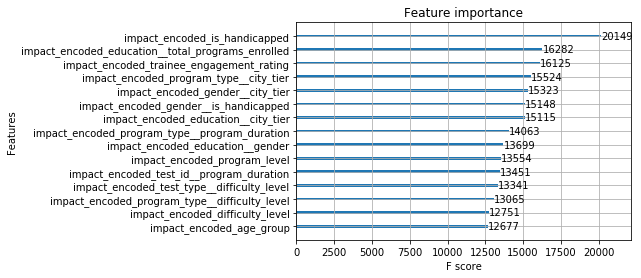

In [21]:
xgb.plot_importance(model, max_num_features=15, importance_type='weight');

In [37]:
len(df_test.columns), len(np.unique(df_test.columns))

(64, 63)

In [38]:
df_test.columns.value_counts().sort_values(ascending=False)[:2]

one_hot_Y      2
one_hot_2.0    1
dtype: int64

In [39]:
len(df_raw.columns), len(np.unique(df_raw.columns))

(64, 63)

In [40]:
set(df_raw.columns) - set(df_test.columns)

set()

In [41]:
set(df_test.columns) - set(df_raw.columns)

set()

In [42]:
df_test.drop(['one_hot_Y'], axis =1, inplace=True)

In [43]:
df_raw.drop(['one_hot_Y','one_hot_60.0'], axis =1, inplace=True)

## nn

In [8]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, LeakyReLU, Dropout
from keras.activations import relu, softmax
from keras import metrics

Using TensorFlow backend.


In [9]:
model = Sequential()

In [10]:
df_raw.shape

(73147, 56)

In [64]:
def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim = df_raw.shape[1], activation = 'relu', kernel_initializer='normal'))
    model.add(Dense(128, activation = 'relu',kernel_initializer='normal'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation = 'relu',kernel_initializer='normal'))
    model.add(Dropout(0.13))
    model.add(Dense(32,activation = 'relu',kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(16,activation = 'relu',kernel_initializer='normal'))
    model.add(Dropout(0.1))
    model.add(Dense(1,kernel_initializer='normal',activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'],)
    return model

In [65]:
model = build_model()

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               16128     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
__________

In [53]:
df_test.fillna(36.,inplace=True, axis =1)

In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(df_raw)
X_test = scaler.transform(df_test)

In [68]:
hist = model.fit(X_train,target,epochs = 25,batch_size = 32,verbose=2,validation_split=.2)

Train on 58517 samples, validate on 14630 samples
Epoch 1/25
18s - loss: 0.4988 - acc: 0.7604 - val_loss: 0.5807 - val_acc: 0.7286
Epoch 2/25
19s - loss: 0.4991 - acc: 0.7606 - val_loss: 0.5582 - val_acc: 0.7284
Epoch 3/25
20s - loss: 0.4982 - acc: 0.7599 - val_loss: 0.5757 - val_acc: 0.7273
Epoch 4/25
19s - loss: 0.4987 - acc: 0.7621 - val_loss: 0.5838 - val_acc: 0.7242
Epoch 5/25
18s - loss: 0.4977 - acc: 0.7615 - val_loss: 0.5657 - val_acc: 0.7295
Epoch 6/25
17s - loss: 0.4982 - acc: 0.7606 - val_loss: 0.6031 - val_acc: 0.7240
Epoch 7/25
17s - loss: 0.4963 - acc: 0.7625 - val_loss: 0.5677 - val_acc: 0.7267
Epoch 8/25
22s - loss: 0.4948 - acc: 0.7633 - val_loss: 0.5718 - val_acc: 0.7245
Epoch 9/25
17s - loss: 0.4953 - acc: 0.7640 - val_loss: 0.5769 - val_acc: 0.7282
Epoch 10/25
18s - loss: 0.4948 - acc: 0.7629 - val_loss: 0.5622 - val_acc: 0.7298
Epoch 11/25
17s - loss: 0.4929 - acc: 0.7660 - val_loss: 0.6058 - val_acc: 0.7267
Epoch 12/25
17s - loss: 0.4935 - acc: 0.7634 - val_loss: 

In [69]:
preds = model.predict_proba(X_test)

31349/31349 [==============================] - ETA: 61 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s     


In [70]:
# serialize model to JSON
model_json = model.to_json()
with open(f'{PATH}\\AV_Stud\\model.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(f"{PATH}\\AV_Stud\\model.h5")
print("Saved model to disk")

Saved model to disk


load json and create model
json_file = open('model.json', 'r')

loaded_model_json = json_file.read()

json_file.close()

loaded_model = model_from_json(loaded_model_json)

load weights into new model

loaded_model.load_weights("model.h5")

print("Loaded model from disk")
 
evaluate loaded model on test data

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

score = loaded_model.evaluate(X, Y, verbose=0)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [71]:
preds[12]

array([ 0.87713], dtype=float32)

In [72]:
new_preds = []

In [73]:
for i in range(df_test.shape[0]):
    new_preds.append(preds[i][0])